In [150]:
ALGORITHM = 'Neural Network'
ALGORITHM_DETAIL = 'random search'
ALGORITHM_DETAIL_ORIG = ALGORITHM_DETAIL
ALGORITHM_DETAIL += ' [input11, d^20-500-500-20-5, dense1]'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

OVERRIDE_CV, OVERRIDE_N_ITER, OVERRIDE_JOBS = None, None, None

debug_mode = False
quick_mode = False
quick_mode = True

if quick_mode:
    OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scikeras.wrappers import KerasClassifier, KerasRegressor

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

print(tf.__version__)


def make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse'):
    normalizer = tf.keras.layers.Normalization(axis=-1)
    model = Sequential()
    #model.add(normalizer)
    model.add(Dense(11, input_shape=(len(X_train[0]),), activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1))
    model.compile(loss=loss, optimizer=optimizer)
    #print(model)
    return model


2022-11-10 21:48:56.979368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [3]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

#confirm_colab = True
confirm_colab = False
IN_CLOUD = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB and not IN_CLOUD:
    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221107 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time, get_results, update_results

    set_csv_directory('final_split')
else:
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', 'zfunctions'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time, get_results, update_results


In [4]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [5]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [6]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v06.csv
(46871, 9)


In [7]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [8]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [9]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [10]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [11]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [12]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [13]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [14]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [15]:
# starter_pipe = make_modelling_pipeline(selected_model, DATA_DETAIL)
# starter_pipe

# def make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse'):
#     normalizer = tf.keras.layers.Normalization(axis=-1)
#     model = Sequential()
#     #model.add(normalizer)
#     model.add(Dense(11, input_shape=(len(X_train[0]),), activation='relu'))
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(500, activation='relu'))
#     model.add(Dense(500, activation='relu'))
#     model.add(Dense(20, activation='relu'))
#     model.add(Dense(5, activation='relu'))
#     model.add(Dense(1))
#     model.compile(loss=loss, optimizer=optimizer)
#     #print(model)
#     return model


#starter_pipe = make_modelling_pipeline(make_regression_ann, DATA_DETAIL)
starter_pipe = make_modelling_pipeline(KerasRegressor(make_regression_ann, verbose=0), DATA_DETAIL)
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 KerasRegressor(model=<function make_regression_ann at 0x7fb30d9fc9d0>, verbose=0))])

In [16]:
fitted_graph_model = starter_pipe[-1]
default_model_params = fitted_graph_model.get_params()
default_model_params

{'model': <function __main__.make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse')>,
 'build_fn': None,
 'warm_start': False,
 'random_state': None,
 'optimizer': 'rmsprop',
 'loss': None,
 'metrics': None,
 'batch_size': None,
 'validation_batch_size': None,
 'verbose': 0,
 'callbacks': None,
 'validation_split': 0.0,
 'shuffle': True,
 'run_eagerly': False,
 'epochs': 1}

In [72]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [73]:
# SKIP %timeit starter_pipe.fit(X_train, y_train)

In [74]:
# options_block = {
#     #'initializer': ['normal', 'uniform'],
#     #'activation': ['relu', 'sigmoid'],
#     'optimizer': ['adam', 'rmsprop'],
#     'loss': ['mse', 'mae'],
#     'batch_size': [32, 64, 100, 1000, 10000],
#     'epochs': [5, 10, 100, 1000, 10000],
# }

options_block = {
    'model__model__initializer': ['normal'],
    'model__model__activation': ['relu'],
    'model__optimizer': ['adam'],
    'model__loss': ['mse'],  #, 'mae'],
    #'model__verbose':[1],
    'model__batch_size': [1000],
    'model__epochs': [5]  #00],
}

options_block = {
    'model__model__initializer': ['normal'], #, 'uniform'],
    'model__model__activation': ['relu','sigmoid'],
    'model__optimizer': ['adam','rmsprop'],
    'model__loss': ['mse'], #, 'mae'],
    #'model__verbose':[1],
    #'model__batch_size': [32, 64, 100, 1000, 10000],
    'model__batch_size': [100,1000,10000],
    #'model__epochs': [5, 10, 100] #, 1000, 10000],
    'model__epochs': [10, 100, 500],
}

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

pipeline_search_cv = make_modelling_pipeline(KerasRegressor(make_regression_ann, verbose=1), DATA_DETAIL)

if False:
    grid_search = RandomizedSearchCV(
        #estimator=KerasRegressor(make_regression_ann, verbose=0),
        estimator=pipeline_search_cv,
        param_distributions=options_block,
        #scoring='r2',
        #scoring='neg_mean_absolute_percentage_error',
        #scoring='neg_mean_squared_error',
        scoring='r2',
        cv=3, n_jobs=1, # 3,
        error_score='raise',
        n_iter=3,  # 1, #3
        return_train_score=True, #n_iter=n_iter,
        verbose=1
    )

    #X, y = make_regression(n_features=7, n_samples=100, random_state=42)

    grid_search.fit(X_train, y_train)
    grid_search.best_params_

In [75]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


crossval_runner = RandomizedSearchCV(
    estimator=pipeline_search_cv,
    param_distributions=options_block,
    cv=cv, n_jobs=n_jobs, # get the AVX/AVX2 info if use n_jobs > 2
    verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
    refit=refit,
    return_train_score=True, #n_iter=n_iter,
    n_iter=n_iter,  # 1, #3
    error_score='raise'
)

cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
    crossval_runner, X_train, y_train, fits=cv * n_iter)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


2022-11-10 22:23:35.665208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 22:23:35.835319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 22:23:35.840894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate co

Epoch 1/10
Epoch 1/100
Epoch 1/10
2/2 [==============================] - 3s 499ms/step - loss: 192443924480.0000
Epoch 2/100
2/2 [==============================] - 1s 435ms/step - loss: 192443531264.0000
Epoch 3/100
199/199 [==============================] - 4s 13ms/step - loss: 111387140096.0000
Epoch 2/10
2/2 [==============================] - 1s 457ms/step - loss: 192442105856.0000
Epoch 5/100
2/2 [==============================] - 1s 593ms/step - loss: 192440827904.0000
Epoch 6/100
199/199 [==============================] - 4s 18ms/step - loss: 14017078272.0000
Epoch 3/10
2/2 [==============================] - 1s 495ms/step - loss: 192439009280.0000
Epoch 7/100
199/199 [==============================] - 4s 18ms/step - loss: 15019255808.0000
Epoch 3/10
2/2 [==============================] - 1s 519ms/step - loss: 192436404224.0000
Epoch 8/100
2/2 [==============================] - 1s 440ms/step - loss: 192432799744.0000
Epoch 9/100
2/2 [==============================] - 1s 629ms/step

2022-11-10 23:36:10.483427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 23:36:10.677395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 23:36:10.693749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate co

Epoch 1/10
Epoch 1/10
Epoch 1/10
2/2 [==============================] - 2s 528ms/step - loss: 192245399552.0000
Epoch 2/10
2/2 [==============================] - 3s 505ms/step - loss: 192444039168.0000
Epoch 2/10
2/2 [==============================] - 1s 467ms/step - loss: 192245202944.0000
Epoch 3/10
Epoch 2/10
2/2 [==============================] - 1s 432ms/step - loss: 192443842560.0000
Epoch 3/10
2/2 [==============================] - 1s 442ms/step - loss: 192244989952.0000
Epoch 4/10
2/2 [==============================] - 1s 492ms/step - loss: 192443629568.0000
Epoch 4/10
199/199 [==============================] - 2s 11ms/step - loss: 13255536640.0000
Epoch 3/10
2/2 [==============================] - 1s 438ms/step - loss: 192443301888.0000
Epoch 5/10
2/2 [==============================] - 1s 432ms/step - loss: 192244105216.0000
Epoch 6/10
2/2 [==============================] - 1s 469ms/step - loss: 192442761216.0000
Epoch 6/10
2/2 [==============================] - 1s 464ms/step -

In [76]:
crossval_runner.best_params_

{'model__optimizer': 'adam',
 'model__model__initializer': 'normal',
 'model__model__activation': 'sigmoid',
 'model__loss': 'mse',
 'model__epochs': 500,
 'model__batch_size': 100}

In [77]:
best_estimator_pipe = crossval_runner.best_estimator_

if debug_mode:
    cross_validation_result.cv_results_

In [110]:
cv_results_df = pd.DataFrame(crossval_runner.cv_results_)

cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time','params']
# if 'Neural' not in ALGORITHM:
#     cv_columns.insert(2, 'mean_train_score')

cv_results_df_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)
cv_results_df_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,adam/normal/sigmoid/mse/500/100,1,0.545239,1019.623069,1.021304,"{'model__optimizer': 'adam', 'model__model__in..."
1,rmsprop/normal/relu/mse/100/1000,2,0.493875,99.367626,0.936212,"{'model__optimizer': 'rmsprop', 'model__model_..."
2,adam/normal/relu/mse/10/100,3,0.471584,23.019259,2.658868,"{'model__optimizer': 'adam', 'model__model__in..."
3,adam/normal/relu/mse/100/10000,4,-0.189201,80.706518,0.607367,"{'model__optimizer': 'adam', 'model__model__in..."
4,rmsprop/normal/sigmoid/mse/100/10000,5,-0.294207,77.938280,0.550912,"{'model__optimizer': 'rmsprop', 'model__model_..."
5,rmsprop/normal/relu/mse/10/1000,6,-0.319116,11.891835,0.912008,"{'model__optimizer': 'rmsprop', 'model__model_..."
6,rmsprop/normal/sigmoid/mse/10/100,7,-7.558850,23.162873,2.587342,"{'model__optimizer': 'rmsprop', 'model__model_..."
7,adam/normal/sigmoid/mse/10/100,8,-7.576194,23.672287,1.895568,"{'model__optimizer': 'adam', 'model__model__in..."
8,adam/normal/sigmoid/mse/10/10000,9,-15.705116,10.937827,0.705089,"{'model__optimizer': 'adam', 'model__model__in..."
9,adam/normal/relu/mse/10/10000,10,-15.705442,8.817066,0.487401,"{'model__optimizer': 'adam', 'model__model__in..."


In [111]:
def print_results(cross_validation_result):
    means = cross_validation_result.cv_results_['mean_test_score']
    stds = cross_validation_result.cv_results_['std_test_score']
    params = cross_validation_result.cv_results_['params']
    times = cross_validation_result.cv_results_['std_test_score']

    print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
    print()
    for mean, std, param, time in zip(means, stds, params, times):
        #param2 = "/".join(list(param.values()))
        param2 = "/".join(list([str(c) for c in param.values()]))
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


if debug_mode:
    print_results(cross_validation_result)

In [112]:
print('Best Index: ', crossval_runner.best_index_)
print('Best Score: ', crossval_runner.best_score_)
print('Best Params: ', crossval_runner.best_params_)

Best Index:  6
Best Score:  0.5452388142552568
Best Params:  {'model__optimizer': 'adam', 'model__model__initializer': 'normal', 'model__model__activation': 'sigmoid', 'model__loss': 'mse', 'model__epochs': 500, 'model__batch_size': 100}


In [113]:
y_pred = best_estimator_pipe.predict(X_test)

45/45 [==============================] - 0s 5ms/step


In [114]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Neural Network----------
R square Accuracy 0.6066961181655233
Mean Absolute Error Accuracy 52689.052345343305
Mean Squared Error Accuracy 4442920184.587973
Root Mean Squared Error 66655.2337374041


In [115]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [116]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,370099.56250,29900.43750,7.475109,8.079025
119328242,369950.0,406625.31250,36675.31250,9.913586,9.019437
125716790,350000.0,395374.37500,45374.37500,12.964107,11.476306
122440040,549000.0,542496.75000,6503.25000,1.184563,1.198763
120508103,495000.0,505377.31250,10377.31250,2.096427,2.053379
...,...,...,...,...,...
68620869,475000.0,529916.31250,54916.31250,11.561329,10.363205
85735665,575000.0,561377.68750,13622.31250,2.369098,2.426586
125706338,400000.0,426035.93750,26035.93750,6.508984,6.111207


In [117]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted','actual','Price','bedrooms','bathrooms']] = combined[['predicted','actual','Price','bedrooms','bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,532620,372620.56250,232.887852,69.959853,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
109722224,108000,338070,230070.12500,213.027894,68.053965,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
85667184,122000,321670,199670.59375,163.664421,62.073002,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
83639617,190000,450310,260310.12500,137.005329,57.806856,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
119684411,200000,428122,228122.59375,114.061297,53.284409,200000,2,1,0.511626,51.518081,-0.029340,0.018361,0.075080,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125442320,375000,374833,166.81250,0.044483,0.044503,375000,2,1,0.682388,51.591131,-0.266880,0.091411,0.162460,LEASEHOLD
109208819,275000,275110,110.00000,0.040000,0.039984,275000,1,1,0.152737,51.395330,-0.172040,0.104390,0.067620,LEASEHOLD
126011609,515000,514896,103.84375,0.020164,0.020168,515000,2,2,0.131616,51.426790,-0.170920,0.072930,0.066500,SHARE_OF_FREEHOLD
123772811,335000,334955,44.15625,0.013181,0.013183,335000,1,1,0.531442,51.639144,-0.110564,0.139424,0.006144,SHARE_OF_FREEHOLD


In [118]:
score = best_estimator_pipe.score(X_test, y_test)
score

45/45 [==============================] - 0s 5ms/step


0.6066961181655233

In [119]:
r2_score(y_test, y_pred)

0.6066961181655233

45/45 [==============================] - 0s 4ms/step


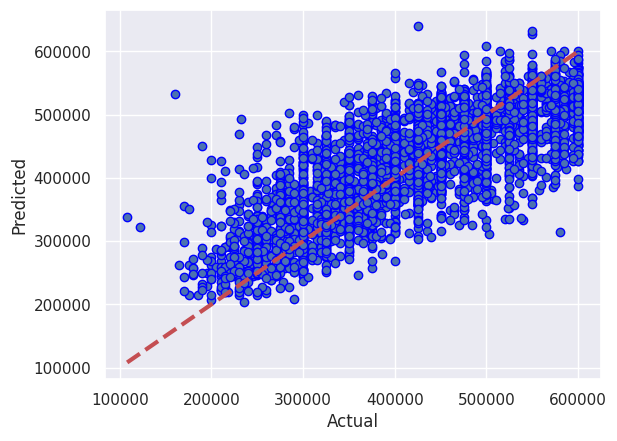

In [120]:
fig, ax = plt.subplots()
ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [144]:
def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
    graph_model = model
    graph_model.set_params(**graph_params)
    graph_model.fit(X_train, y_train)
    y_pred_graph = model.predict(X_test)

    return model, y_pred_graph


best_model_count = 10 if not quick_mode else 2
best_model_count = 3 if not quick_mode else 1
best_models = {}
best_model_predictions = {}
best_model_scores = {}

showable_increment = total_fits // 4 if not quick_mode else 2
for i in range(0, total_fits, showable_increment):
    if debug_mode or True: print(f'{i} ==> {i}')

    if i == 0:
        fitted_graph_model = crossval_runner.best_estimator_
        y_pred_graph = y_pred
    else:
        graph_pipe_params = cv_results_df_sorted['params'][i]
        print (graph_pipe_params)
        # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

        graph_params = {}
        for key, value in graph_pipe_params.items():
            graph_params[key.replace('model__', '')] = value

        fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                        y_train, X_test)

    best_models[i] = fitted_graph_model[-1].get_params()
    best_model_predictions[i] = y_pred_graph
    best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

if debug_mode or True: print(f'{-1} ==> {-1}')
graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
print (graph_pipe_params)
graph_params = {}
for key, value in graph_pipe_params.items():
    graph_params[key.replace('model__', '')] = value
fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                y_train, X_test)
best_models[-1] = fitted_graph_model[-1].get_params()
best_model_predictions[-1] = y_pred_graph
best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
45/45 [==============================] - 0s 4ms/step
2 ==> 2
{'model__optimizer': 'adam', 'model__model__initializer': 'normal', 'model__model__activation': 'relu', 'model__loss': 'mse', 'model__epochs': 10, 'model__batch_size': 100}
4 ==> 4
{'model__optimizer': 'rmsprop', 'model__model__initializer': 'normal', 'model__model__activation': 'sigmoid', 'model__loss': 'mse', 'model__epochs': 100, 'model__batch_size': 10000}
6 ==> 6
{'model__optimizer': 'rmsprop', 'model__model__initializer': 'normal', 'model__model__activation': 'sigmoid', 'model__loss': 'mse', 'model__epochs': 10, 'model__batch_size': 100}
8 ==> 8
{'model__optimizer': 'adam', 'model__model__initializer': 'normal', 'model__model__activation': 'sigmoid', 'model__loss': 'mse', 'model__epochs': 10, 'model__batch_size': 10000}
-1 ==> -1
{'model__optimizer': 'adam', 'model__model__initializer': 'normal', 'model__model__activation': 'relu', 'model__loss': 'mse', 'model__epochs': 10, 'model__batch_size': 10000}


In [145]:
cv_results_df_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,adam/normal/sigmoid/mse/500/100,1,0.545239,1019.623069,1.021304,"{'model__optimizer': 'adam', 'model__model__in..."
1,rmsprop/normal/relu/mse/100/1000,2,0.493875,99.367626,0.936212,"{'model__optimizer': 'rmsprop', 'model__model_..."
2,adam/normal/relu/mse/10/100,3,0.471584,23.019259,2.658868,"{'model__optimizer': 'adam', 'model__model__in..."
3,adam/normal/relu/mse/100/10000,4,-0.189201,80.706518,0.607367,"{'model__optimizer': 'adam', 'model__model__in..."
4,rmsprop/normal/sigmoid/mse/100/10000,5,-0.294207,77.938280,0.550912,"{'model__optimizer': 'rmsprop', 'model__model_..."
5,rmsprop/normal/relu/mse/10/1000,6,-0.319116,11.891835,0.912008,"{'model__optimizer': 'rmsprop', 'model__model_..."
6,rmsprop/normal/sigmoid/mse/10/100,7,-7.558850,23.162873,2.587342,"{'model__optimizer': 'rmsprop', 'model__model_..."
7,adam/normal/sigmoid/mse/10/100,8,-7.576194,23.672287,1.895568,"{'model__optimizer': 'adam', 'model__model__in..."
8,adam/normal/sigmoid/mse/10/10000,9,-15.705116,10.937827,0.705089,"{'model__optimizer': 'adam', 'model__model__in..."
9,adam/normal/relu/mse/10/10000,10,-15.705442,8.817066,0.487401,"{'model__optimizer': 'adam', 'model__model__in..."


In [146]:
cv_results_df_sorted['params']

0    {'model__optimizer': 'adam', 'model__model__in...
1    {'model__optimizer': 'rmsprop', 'model__model_...
2    {'model__optimizer': 'adam', 'model__model__in...
3    {'model__optimizer': 'adam', 'model__model__in...
4    {'model__optimizer': 'rmsprop', 'model__model_...
5    {'model__optimizer': 'rmsprop', 'model__model_...
6    {'model__optimizer': 'rmsprop', 'model__model_...
7    {'model__optimizer': 'adam', 'model__model__in...
8    {'model__optimizer': 'adam', 'model__model__in...
9    {'model__optimizer': 'adam', 'model__model__in...
Name: params, dtype: object

In [147]:
total_fits

10

In [148]:
best_models

{0: {'model': <function __main__.make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse')>,
  'build_fn': None,
  'warm_start': False,
  'random_state': None,
  'optimizer': 'adam',
  'loss': 'mse',
  'metrics': None,
  'batch_size': 100,
  'validation_batch_size': None,
  'verbose': 1,
  'callbacks': None,
  'validation_split': 0.0,
  'shuffle': True,
  'run_eagerly': False,
  'epochs': 500,
  'model__initializer': 'normal',
  'model__activation': 'sigmoid'},
 2: {'model': <function __main__.make_regression_ann(initializer='uniform', activation='relu', optimizer='adam', loss='mse')>,
  'build_fn': None,
  'warm_start': False,
  'random_state': None,
  'optimizer': 'adam',
  'loss': 'mse',
  'metrics': None,
  'batch_size': 100,
  'validation_batch_size': None,
  'verbose': 0,
  'callbacks': None,
  'validation_split': 0.0,
  'shuffle': True,
  'run_eagerly': False,
  'epochs': 10,
  'model__initializer': 'normal',
  'model__activation': 'relu'},
 4: 

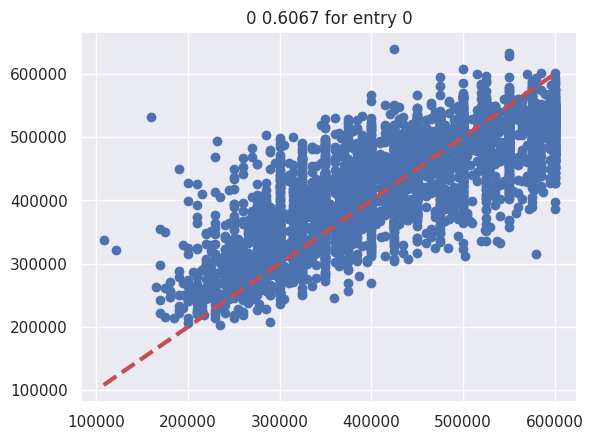

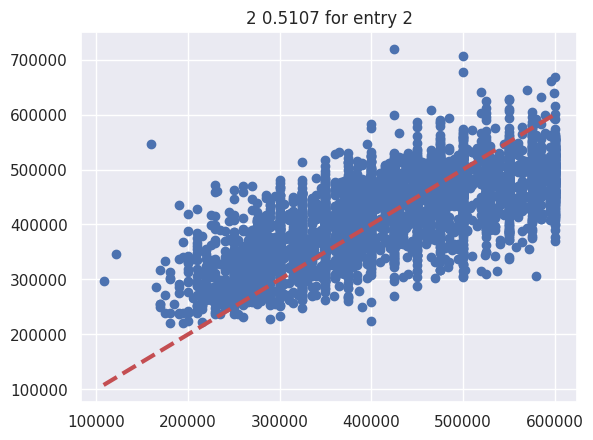

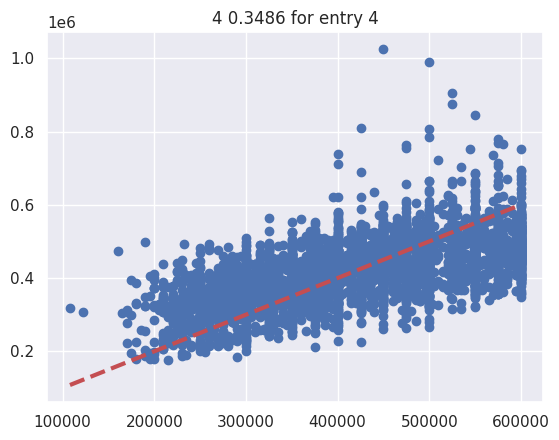

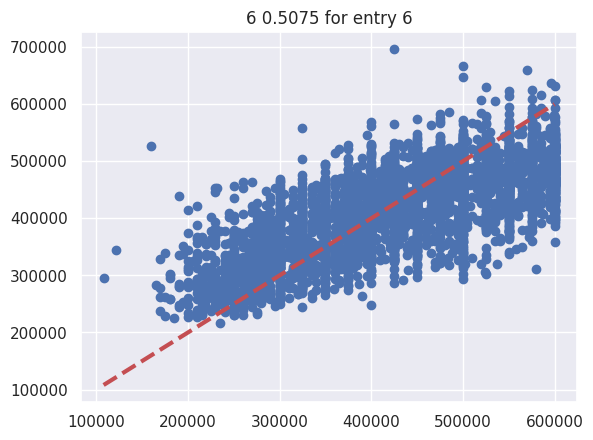

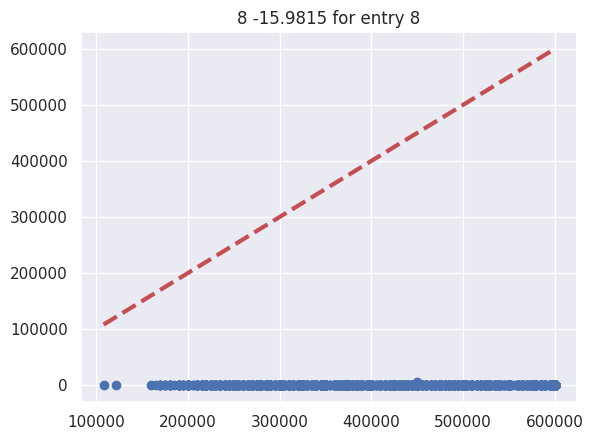

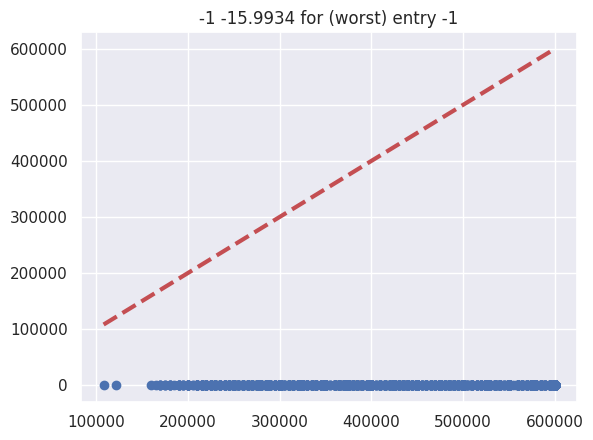

In [149]:
for i in best_model_scores.keys():
    if i >= 0:
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        plt.scatter(y_test, best_model_predictions[i])
        # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
        plt.show()

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.scatter(y_test, best_model_predictions[-1])
# plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))
plt.show()

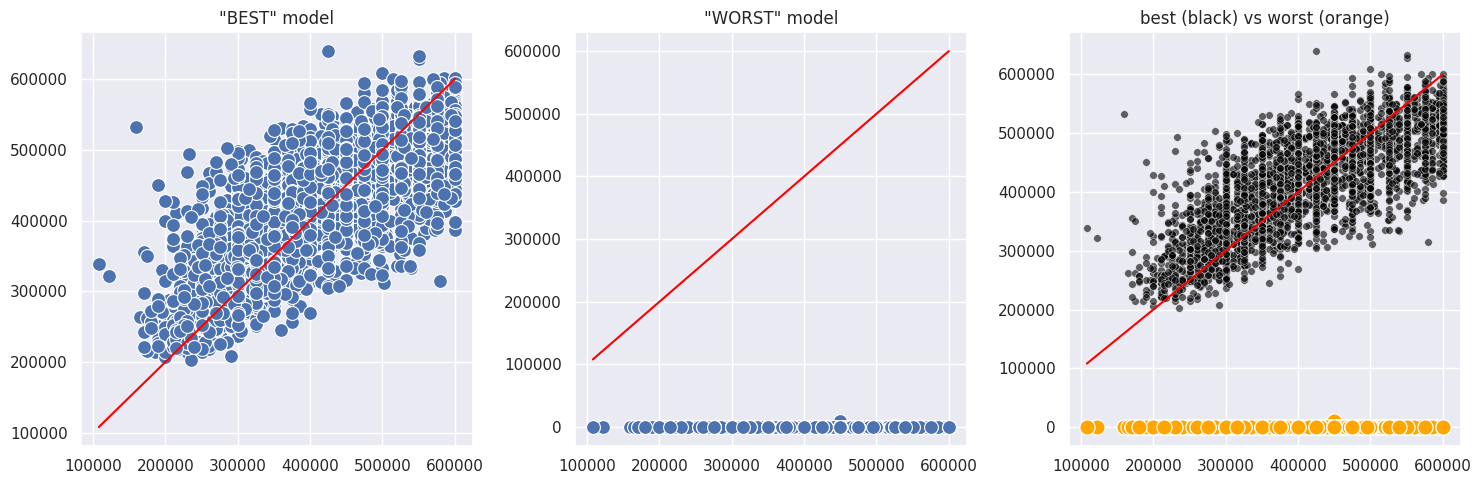

In [127]:
if True:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [134]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
#cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time

1019.6230691671371

In [151]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]

DD2 = "(".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} - {ALGORITHM_DETAIL}{DD2} (v{VERSION})'.lower()

results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': crossval_runner.best_params_
}

if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results, key)

print(key)
results

neural network - random search [input11, d^20-500-500-20-5, dense1] (v06)


{'_score': 0.6066961181655233,
 'R square Accuracy': 0.6066961181655233,
 'Mean Absolute Error Accuracy': 52689.052345343305,
 'Mean Squared Error Accuracy': 4442920184.587973,
 'Root Mean Squared Error': 66655.2337374041,
 '_train time': 1019.6230691671371,
 'random_state': 101,
 'date': '2022-11-11 01:20:17.646731',
 'params': {'model__optimizer': 'adam',
  'model__model__initializer': 'normal',
  'model__model__activation': 'sigmoid',
  'model__loss': 'mse',
  'model__epochs': 500,
  'model__batch_size': 100},
 'first run': '2022-11-11 01:20:17.647823',
 'best params': {'model__optimizer': 'adam',
  'model__model__initializer': 'normal',
  'model__model__activation': 'sigmoid',
  'model__loss': 'mse',
  'model__epochs': 500,
  'model__batch_size': 100},
 'best score': 0.6066961181655233,
 'suboptimal': 'pending'}

In [138]:
crossval_runner.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 KerasRegressor(batch_size=100, epochs=500, loss='mse', model=<function make_regression_ann at 0x7fb30d9fc9d0>, model__activation='sigmoid', model__initializer='normal', optimizer='adam'))])

In [140]:
with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
    pickle.dump(crossval_runner.best_estimator_, f)

INFO:tensorflow:Assets written to: ram:///tmp/tmpndy5cd6v/assets


In [142]:
feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

indices = np.argsort(feature_importances)[::-1]

print('Feature Ranking:')

for f in range(X_train.shape[1]):
    print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
          df_features.columns[indices[f] + 1])


AttributeError: 'KerasRegressor' object has no attribute 'feature_importances_'

In [143]:
feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
indices = np.argsort(feature_importances)

fig, ax = plt.subplots()
ax.barh(range(len(feature_importances)), feature_importances[indices])
ax.set_yticks(range(len(feature_importances)))
_ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])

AttributeError: 'KerasRegressor' object has no attribute 'feature_importances_'